In [2]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
import logging
import numpy as np
import copy 
import shutil

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from environment_creator import EnvironmentCreator
import argparse

def bool_arg(string):
    value = string.lower()
    if value == 'true':
        return True
    elif value == 'false':
        return False
    else:
        raise argparse.ArgumentTypeError("Expected True or False, but got {}".format(string))

def get_arg_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('-g', default='pong', help='Name of game', dest='game')
    parser.add_argument('-d', '--device', default='/gpu:0', type=str, help="Device to be used ('/cpu:0', '/gpu:0', '/gpu:1',...)", dest="device")
    parser.add_argument('--rom_path', default='./atari_roms', help='Directory where the game roms are located (needed for ALE environment)', dest="rom_path")
    parser.add_argument('-v', '--visualize', default=False, type=bool_arg, help="0: no visualization of emulator; 1: all emulators, for all actors, are visualized; 2: only 1 emulator (for one of the actors) is visualized", dest="visualize")
    parser.add_argument('--e', default=0.1, type=float, help="Epsilon for the Rmsprop and Adam optimizers", dest="e")
    parser.add_argument('--alpha', default=0.99, type=float, help="Discount factor for the history/coming gradient, for the Rmsprop optimizer", dest="alpha")
    parser.add_argument('-lr', '--initial_lr', default=0.0224, type=float, help="Initial value for the learning rate. Default = 0.0224", dest="initial_lr")
    parser.add_argument('-lra', '--lr_annealing_steps', default=80000000, type=int, help="Nr. of global steps during which the learning rate will be linearly annealed towards zero", dest="lr_annealing_steps")
    parser.add_argument('--entropy', default=0.02, type=float, help="Strength of the entropy regularization term (needed for actor-critic)", dest="entropy_regularisation_strength")
    parser.add_argument('--clip_norm', default=3.0, type=float, help="If clip_norm_type is local/global, grads will be clipped at the specified maximum (avaerage) L2-norm", dest="clip_norm")
    parser.add_argument('--clip_norm_type', default="global", help="Whether to clip grads by their norm or not. Values: ignore (no clipping), local (layer-wise norm), global (global norm)", dest="clip_norm_type")
    parser.add_argument('--gamma', default=0.99, type=float, help="Discount factor", dest="gamma")
    parser.add_argument('--max_global_steps', default=80000000, type=int, help="Max. number of training steps", dest="max_global_steps")
    parser.add_argument('--max_local_steps', default=5, type=int, help="Number of steps to gain experience from before every update.", dest="max_local_steps")
    parser.add_argument('--arch', default='NIPS', help="Which network architecture to use: from the NIPS or NATURE paper", dest="arch")
    parser.add_argument('--single_life_episodes', default=False, type=bool_arg, help="If True, training episodes will be terminated when a life is lost (for games)", dest="single_life_episodes")
    parser.add_argument('-ec', '--emulator_counts', default=32, type=int, help="The amount of emulators per agent. Default is 32.", dest="emulator_counts")
    parser.add_argument('-ew', '--emulator_workers', default=8, type=int, help="The amount of emulator workers per agent. Default is 8.", dest="emulator_workers")
    parser.add_argument('-df', '--debugging_folder', default='logs/', type=str, help="Folder where to save the debugging information.", dest="debugging_folder")
    parser.add_argument('-rs', '--random_start', default=True, type=bool_arg, help="Whether or not to start with 30 noops for each env. Default True", dest="random_start")
    return parser



In [63]:
def public_methods(obj):
    for m in dir(obj):
        if not m.startswith('_'):
            print(m)

def init_args(random_seed=3):
    args = get_arg_parser().parse_args(['-g', 'pong', '-df', 'logs/'])
    args.random_seed = random_seed
    return args

def print_env_associated_args(args):
    for arg in ['rom_path', 'game', 'random_seed', 'random_start', 'single_life_episodes', 'visualize']:
        value = getattr(args, arg)
        print('%s:' % arg, value)
        
def get_EnvironmentCreator():
    args = init_args()
    print('Creator arguments:')
    print_env_associated_args(args)
    env_creator = EnvironmentCreator(args)
    return env_creator
    

    

env_creator = get_EnvironmentCreator()

Creator arguments:
rom_path: ./atari_roms
game: pong
random_seed: 3
random_start: True
single_life_episodes: False
visualize: False


In [64]:
env = env_creator.create_environment(0)


In [65]:
import numpy as np
state = env.get_initial_state()
print(state.shape, state.dtype)
print(state.max(), state.min())

(84, 84, 4) uint8
236 87


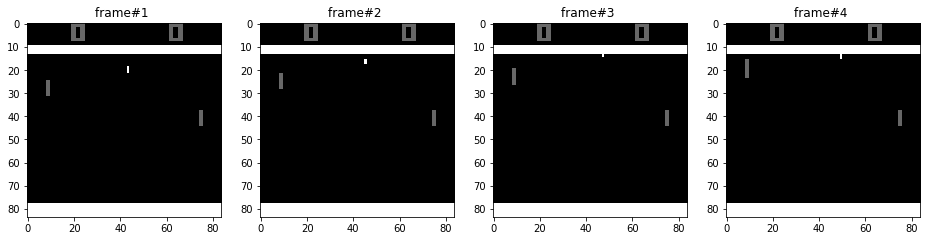

step39


In [66]:
from IPython.display import clear_output

def show_state(state, width=16, height=8):
    _,_, T = state.shape
    fig = plt.figure(figsize=(width, height))
    for i in range(T):
        a = fig.add_subplot(1,T,i+1)
        plt.imshow(state[:,:,i], cmap='gray')
        a.set_title('frame#%d '% (i+1))
    plt.show()

env.get_initial_state()
for i in range(40):
    obs, r, terminal = env.next(env.get_noop())
    show_state(obs)
    print('step%d' % i)
    clear_output(wait=True)

In [67]:
import torch.nn.init as nn_init

def init_conv2d(module):
    (h, w), c = module.kernel_size, module.in_channels
    d = 1.0 / np.sqrt(c*h*w)
    
    nn_init.uniform(module.weight, -d, d)
    nn_init.uniform(module.bias, -d, d)
    

def init_linear(module):
    d = 1.0 / np.sqrt(module.in_features)
    nn_init.uniform(module.weight, -d, d)
    nn_init.uniform(module.bias, -d, d)

    
def init_model_weights(module):
    if isinstance(module, nn.Linear):
        init_linear(module)
    elif isinstance(module, nn.Conv2d):
        init_conv2d(module)


In [68]:
def process_state(s):
    # We need s.transpose because AtariEmulator returns states with shape (H,W,C), but
    # pytorch conv layers expect inputs of shape (C,H,W)
    # if needed it is possible to change AtariEmulator output shape via changing the ObservationPool class.
    return torch.from_numpy(np.ascontiguousarray(s.transpose(2,0,1),dtype=np.float32)/255.)

class FFNetwork(nn.Module):
    def __init__(self, config, input_channels=4):
        super(FFNetwork, self).__init__()
        self._conf = config
        self._loss_scaling = 5.0
        self._create_network(input_channels)
        self.apply(init_model_weights)
    
    def _create_network(self, in_channels):
        self.conv1 = nn.Conv2d(in_channels, 16, (8,8), stride=4)
        self.conv2 = nn.Conv2d(16, 32, (4,4), stride=2)
        #if input shape equals (4, 84,84) then the conv part output shape is: (32, 9, 9)
        #self.__flatten_conv_size = 32*9*9 
        self.fc3 = nn.Linear(32*9*9, 256)
        self.fc_policy = nn.Linear(256, self._conf['num_actions'])
        self.fc_value = nn.Linear(256, 1)
      
        
    def forward(self, inputs):
        x = F.relu(self.conv1(inputs))
        x = F.relu(self.conv2(x))
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc3(x))
        prob = F.softmax(self.fc_policy(x)) #in pytorch A3C an author just outputs logits(the softmax input).
        value = self.fc_value(x)
        return value, prob



In [70]:
def print_config(config_name, dictionary):
    
    def print_dict(d, predicate=''):
        for k, v in d.items():
            print(predicate + '%s:' % k, end=' ')
            if isinstance(v, dict):
                print()
                print_dict(v, predicate + '  ')
            else:
                print(str(v))
    
    header = '{0} {1} {0}'.format('=='*10, config_name)
    print(header)
    print_dict(dictionary)
    print('='*len(header))
    
    
def test_FFNetwork(env, num_actions, random_seed=3):
    import network
    
    args = init_args()
    args.num_actions = num_actions
    args.random_seed = random_seed
    network_conf = {'num_actions': args.num_actions,
                    'entropy_regularisation_strength': args.entropy_regularisation_strength,
                    'device': 0,
                    'clip_norm': args.clip_norm,
                    'clip_norm_type': args.clip_norm_type,
                    'name':'PAAC'}
    gpu_id = network_conf['device']
    Tensor = torch.FloatTensor if gpu_id < 0 else torch.cuda.FloatTensor
    
    print_config('network_conf', network_conf)
    my_model = network.FFNetwork(copy.copy(network_conf))
    print('args.device:', network_conf['device'])
    my_model.cuda(network_conf['device'])
    state = env.get_initial_state()
    state = process_state(state).unsqueeze(0)
    value, act_logits = my_model(Variable(state).type(Tensor))
    
    print('Value:', value)
    print('prob:', F.softmax(act_logits))
    print('Model:')
    print(my_model)
    
    return my_model
    
    
model = test_FFNetwork(env, env_creator.num_actions)
del model

==================== network_conf ====================
num_actions: 6
device: 0
clip_norm: 3.0
entropy_regularisation_strength: 0.02
clip_norm_type: global
name: PAAC
args.device: 0
Value: Variable containing:
1.00000e-02 *
 -2.1845
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

prob: Variable containing:
 0.1692  0.1659  0.1646  0.1583  0.1678  0.1743
[torch.cuda.FloatTensor of size 1x6 (GPU 0)]

Model:
FFNetwork (
  (conv1): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (fc3): Linear (2592 -> 256)
  (fc_policy): Linear (256 -> 6)
  (fc_value): Linear (256 -> 1)
)


In [10]:
def compare_ways_of_creating_EmulatorRunners_inputs(res1, res2):
    if len(res1) != len(res2):
        return False
    
    cmp_funs = [
        lambda i1, i2: i1 == i2, #indices are equal
        lambda ems1, ems2: np.array_equal(ems1, ems2), #emulators are equal
        lambda vars1, vars2: all(np.array_equal(v1,v2) for v1, v2 in zip(vars1, vars2))
    ]
    
    for i in range(len(res1)):
        worker_i_res_are_equal = all(fun(res1[i][j], res2[i][j]) for j, fun in enumerate(cmp_funs))
        if worker_i_res_are_equal is False:
            return False
    
    return True

#%pdoc np.finfo
del env, env_creator

In [71]:
import os
def remove_checkpoint():
    from paac import PAACLearner
    checkpoint = 'logs/checkpoints/'+PAACLearner.CHECKPOINT_LAST
    if os.path.isfile(checkpoint):
        os.remove(checkpoint)

print('cuda is available:', torch.cuda.is_available())
print('num_gpu:', torch.cuda.device_count())
if torch.cuda.is_available():
    print('cuda tensor:', torch.randn(3,3).cuda(), sep='\n')
    
remove_checkpoint()

shutil.rmtree('logs')


cuda is available: True
num_gpu: 1
cuda tensor:

-0.2147 -0.2638 -1.1271
-1.1010 -0.9133  1.0634
-0.1374 -0.9373 -0.5536
[torch.cuda.FloatTensor of size 3x3 (GPU 0)]



In [76]:
import time, copy 
import network as network

def print_args(args):
    print('ARGS:')
    for key,val in vars(args).items():
        print('"{0}": {1}'.format(key,val))
    print()
    
def parse_args(command_line='-g pong -df logs/', random_seed=3):
    args = get_arg_parser().parse_args(command_line.split())
    args.random_seed = random_seed
    return args

def adapt_args(args):
    '''Адаптируем аргументы для тестирования моего кода'''
    args.device = 'gpu' #Interprets the number as GPU identifier, if negative value is given, uses cpu. .
    del args.arch
    

def get_network_and_environment_creator(args):
    logging.debug('get_network_and_environment_creator')
    env_creator = EnvironmentCreator(args)
    args.num_actions = env_creator.num_actions

    network_conf = {'num_actions': args.num_actions,
                    'entropy_regularisation_strength': args.entropy_regularisation_strength,
                    'device': args.device,
                    'clip_norm': args.clip_norm,
                    'clip_norm_type': args.clip_norm_type,
                    'name': 'paac_network'}
    
    print_config('network_conf', network_conf)
    
    def network_creator():
        net = network.FFNetwork(copy.copy(network_conf))
        if network_conf['device'] == 'gpu':
            net = net.cuda()
            logging.debug('Moved model computations on a GPU')
        return net
    
    return network_creator, env_creator

def cleanup(learner, env_creator, args):
    learner.cleanup()
    logging.info('Cleanup completed...')
    logging.debug('Deleting PAACLearner, env_creator, args...')
    del learner, env_creator, args

def process_states(s):
    # We need s.transpose because shared_states are given in shape (batch, H,W,C), but
    # pytorch conv layers expect inputs of shape (batch, C,H,W)
    # if needed it is possible to change AtariEmulator output shape via changing the ObservationPool class.
    return torch.from_numpy(np.ascontiguousarray(s.transpose(0,3,1,2),dtype=np.float32)/255.)


def choose_action(self, states):
    num_actions = self.args['num_actions']
    V_state, action_probs = self.network(Variable(process_states(states)))
    acts_one_hot = np.array([np.random.multinomial(1,p.data.numpy()) for p in action_probs])
    return acts_one_hot, V_state, action_probs

def test_train_function(self):
    from emulator_runner import EmulatorRunner
    from runners import Runners
    
    start_step = step = self.global_step + 1
    logging.debug('Starting training at step %d' % start_step)
    num_emulators = self.args['emulator_counts']
    num_actions = self.args['num_actions']
    max_local_steps = self.args['max_local_steps']
    max_global_steps = self.args['max_global_steps']
    total_rewards = []
        
    #states, rewards, is_terminal, actions
    variables = [
        np.asarray([em.get_initial_state() for em in self.emulators], dtype=np.uint8),
        np.zeros(self.args['emulator_counts'], dtype=np.float32),
        np.asarray([False] * self.args['emulator_counts'], dtype=np.float32),
        np.zeros((self.args['emulator_counts'], self.args['num_actions']), dtype=np.float32)
    ]
    logging.debug('Creating runners...')
    self.runners = Runners(EmulatorRunner, self.emulators, self.num_workers, variables)
    self.runners.start()

    shared_vars = self.runners.get_shared_variables()
    shared_s, shared_r, shared_done, shared_a = shared_vars
    #any summaries here?
    emulator_steps = [0] * num_emulators
    total_episode_rewards = [0] * num_emulators

    actions_sum = np.zeros((num_emulators, num_actions))
    y_batch = np.zeros((max_local_steps, num_emulators))
    adv_batch = np.zeros((max_local_steps, num_emulators))
    rewards = np.zeros((max_local_steps, num_emulators))
    states = np.zeros([max_local_steps] + list(shared_s.shape), dtype=np.uint8)
    actions = np.zeros((max_local_steps, num_emulators, num_actions))
    values = np.zeros((max_local_steps, num_emulators))
    not_done_masks = np.zeros((max_local_steps, num_emulators))

    start_time = time.time()

    #while self.global_step < max_global_steps:

    #    loop_time = time.time()

    for t in range(max_local_steps):
        #print(t, 'shared_states shape:', shared_s.shape)
        print('========='*5)
        a_t, v_t, probs_t, log_probs_t = self.choose_action(shared_s)                       
        actions_sum += a_t
        shared_a[:] = a_t[:]
        actions[t] = a_t
        values[t] = v_t.view(-1).data.numpy()
        states[t] = shared_s
        print('actions_one_hot:', a_t, sep='\n')
        print('actions_id:', np.argmax(a_t, 1))
        self.runners.update_environments()
        self.runners.wait_updated()
        
        
        not_done_masks[t] = 1.0 - shared_done.astype(np.float32)
        
        for e, (actual_reward, episode_over) in enumerate(zip(shared_r, shared_done)):
            total_episode_rewards[e] += actual_reward
            actual_reward = np.clip(actual_reward, -1.,1.)
            rewards[t, e] = actual_reward

            emulator_steps[e] += 1
            self.global_step += 1
            if episode_over:
                total_rewards.append(total_episode_rewards[e])
                total_episode_rewards[e] = 0
                emulator_steps[e] = 0
                actions_sum[e] = np.zeros(num_actions)
    
    nest_state_value, _ = self.network(Variable(process_states(shared_s)))
    #nest_state_value = nest_state_value.detach()
    estimated_return = np.copy(nest_state_value.data.numpy()).squeeze()
    
    #fill the targets arrays:
    for t in reversed(range(max_local_steps)):
        estimated_return = rewards[t] + self.gamma * estimated_return * not_done_masks[t]
        y_batch[t] = estimated_return
        adv_batch[t] = estimated_return - values[t]
        
    flat_states = states.reshape((-1,) + states.shape[2:])
    flat_y_batch = y_batch.reshape(-1)
    flat_adv_batch = adv_batch.reshape(-1)
    flat_actions = actions.reshape((-1,) + actions.shape[2:])
    #print('flat_actions:', flat_actions, sep='\n')
    
    #lr = self.get_lr()
    #feed_dict = {self.network.input_ph: flat_states,
    #             self.network.critic_target_ph: flat_y_batch,
    #             self.network.selected_action_ph: flat_actions,
    #             self.network.adv_actor_ph: flat_adv_batch,
    #             self.learning_rate: lr}
    #
    #_, summaries = self.session.run([self.train_step, summaries_op], feed_dict=feed_dict)
           
    logging.debug('Training ended at step %d' % step)
    

def test_paac_and_gradient_clipping(command_line):
    from utils import clip_local_grad_norm
    from paac import PAACLearner
    # Configure logging module to output messages in Jupyter Notebook:
    import logging 
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
    logging.debug("test")
    # -ec = ew = 1 because we need only one emulator for testing purposes
    args = parse_args(command_line) 
    adapt_args(args)
    print_args(args)
    try:
        net_creator, env_creator = get_network_and_environment_creator(args)
        learner = PAACLearner(net_creator, env_creator, args)
        
        #test_train_function(learner)
        learner.train()
        print('Runners:')
        print(learner.runners.runners)
        
        #net = net_creator()
        #if args.device >= 0:
        #    print('use cuda({0})'.format(args.device))
        #    net.cuda(args.device)
        #print('Network:', net, sep='\n')
    finally:
        cleanup(learner, env_creator, args)
        pass 
    
    logging.debug("DONE")

command_line = '-g pong -df logs/ -ec 16 -ew 4'
command_line += ' --max_global_steps 105000 -lra 80000000'
#command_line += ' --clip_norm 0.005 --clip_norm_type ignore'
remove_checkpoint()
test_paac_and_gradient_clipping(command_line)

DEBUG:root:test
DEBUG:root:get_network_and_environment_creator
DEBUG:root:PAAC init is started
DEBUG:root:Moved model computations on a GPU


ARGS:
"emulator_counts": 16
"device": gpu
"random_seed": 3
"max_local_steps": 5
"clip_norm": 3.0
"entropy_regularisation_strength": 0.02
"clip_norm_type": global
"initial_lr": 0.0224
"rom_path": ./atari_roms
"gamma": 0.99
"single_life_episodes": False
"lr_annealing_steps": 80000000
"random_start": True
"visualize": False
"e": 0.1
"max_global_steps": 105000
"emulator_workers": 4
"game": pong
"alpha": 0.99
"debugging_folder": logs/

==================== network_conf ====================
num_actions: 6
device: gpu
clip_norm: 3.0
entropy_regularisation_strength: 0.02
clip_norm_type: global
name: paac_network


DEBUG:root:Paac init is done!
DEBUG:root:Starting training at step 0
DEBUG:root:Creating runners...
INFO:root:Ran 10240 steps, at 1163.1458679977816 steps/s (1174.8949961401875 steps/s avg), last 10 rewards avg 0.0
INFO:root:Ran 20480 steps, at 1232.4860238751148 steps/s (1173.3467932761662 steps/s avg), last 10 rewards avg -20.3
INFO:root:Ran 30720 steps, at 1254.3478439655335 steps/s (1176.0405866607907 steps/s avg), last 10 rewards avg -20.0
INFO:root:Ran 40960 steps, at 681.5407489255218 steps/s (1155.8986887050364 steps/s avg), last 10 rewards avg -20.1
INFO:root:Ran 51200 steps, at 1201.5050667812511 steps/s (1132.97968973752 steps/s avg), last 10 rewards avg -20.1
INFO:root:Ran 61440 steps, at 842.9893402940903 steps/s (1124.9876701591186 steps/s avg), last 10 rewards avg -20.4
INFO:root:Ran 71680 steps, at 1165.1653587054657 steps/s (1110.5334029881144 steps/s avg), last 10 rewards avg -20.3
INFO:root:Ran 81920 steps, at 1050.2531229557198 steps/s (1108.0193227916209 steps/s av

Runners:
[<EmulatorRunner(EmulatorRunner-13, started)>, <EmulatorRunner(EmulatorRunner-14, started)>, <EmulatorRunner(EmulatorRunner-15, started)>, <EmulatorRunner(EmulatorRunner-16, started)>]


In [112]:
def testprobs(N = 10):
    #lambda l: for e in l
    
    probs_list = []
    probs_list.append(np.array([[0.5, 0.5, 0.,0.]]*N))# - np.finfo(np.float32).epsneg
    #action_indexes = [int(np.nonzero(np.random.multinomial(1, p))[0]) for p in probs]
    probs_list.append(np.tile([0.,0.,0.1,.9], (N,1)))
    
    probs = np.concatenate(probs_list)
    
    
    print('probs shape:', probs.shape)
    #print(probs)
    tprobs = torch.from_numpy(probs)
    acts = tprobs.multinomial(1)
    print('acts:', acts, sep='\n')
    first = 0 
    for p in probs_list:
        print('distribution:', p[0])
        last = first + len(p)
        acts_p = acts[first: last]
        sample_probs = [(acts_p == act).type(torch.FloatTensor).mean() for act in range(4)] 
        print('sample probs:', sample_probs)
        first = last   
   #print(actions)
    #unique, counts  = np.unique(action_indexes, return_counts=True)
    #print( list(zip(unique, counts)) )
    
testprobs(5)

probs shape: (10, 4)


AttributeError: 'torch.LongTensor' object has no attribute 'detach'

In [212]:
torch.get_num_threads()

4

(4, 84, 84)


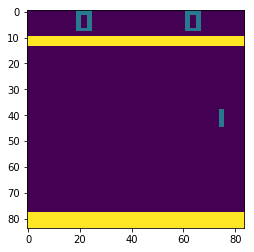

In [118]:
foo = env.get_initial_state()
foo = foo.transpose(2,0,1)
print(foo.shape)
plt.imshow(foo[0])

In [45]:
def test_counter(max_global_steps, num_emulators = 8, max_local_steps=5):
    global_step = 0
    counter = 0
    while global_step <= max_global_steps:
        global_step = counter*max_local_steps*num_emulators
        if counter % (2048/ num_emulators) == 0:
            print(global_step)
        counter += 1

test_counter(100000, num_emulators=32, max_local_steps=5)

0
10240
20480
30720
40960
51200
61440
71680
81920
92160


Test tensorflow code parts from PAAC
==================

In [1]:
from policy_v_network import NIPSPolicyVNetwork, PolicyVNetwork, NIPSNetwork, Network
from environment_creator import EnvironmentCreator
from train import get_arg_parser
import tensorflow as tf
%load_ext autoreload
%autoreload 0

NIPSPolicyVNetwork.mro()

[policy_v_network.NIPSPolicyVNetwork,
 policy_v_network.PolicyVNetwork,
 networks.NIPSNetwork,
 networks.Network,
 object]

In [8]:
def public_methods(obj):
    for m in dir(obj):
        if not m.startswith('_'):
            print(m)

def init_args(random_seed=3):
    args = get_arg_parser().parse_args(['-g', 'pong', '-df', 'logs/'])
    args.random_seed = random_seed
    return args

        
def print_config(config_name, dictionary):
    
    def print_dict(d, predicate=''):
        for k, v in d.items():
            print(predicate + '%s:' % k, end=' ')
            if isinstance(v, dict):
                print()
                print_dict(v, predicate + '  ')
            else:
                print(str(v))
    
    header = '{0} {1} {0}'.format('=='*10, config_name)
    print(header)
    print_dict(dictionary)
    print('='*len(header))


In [7]:
def prepare_network_conf(args, name, num_actions, random_seed=3):
    args.num_actions = num_actions
    args.random_seed = random_seed
    network_conf = {'num_actions': args.num_actions,
                    'entropy_regularisation_strength': args.entropy_regularisation_strength,
                    'device': args.device,
                    'clip_norm': args.clip_norm,
                    'clip_norm_type': args.clip_norm_type,
                    'name':name}
    return network_conf

def test_NIPSnetwork(num_actions, random_seed=3):
    tf.reset_default_graph()
    args = init_args()
    network_conf = prepare_network_conf(args, 'nips_network', num_actions, random_seed)
    print_config('network_conf', network_conf)
    my_model = NIPSPolicyVNetwork(network_conf)
    print('model name:', my_model.name)
    
test_NIPSnetwork(num_actions=6)

==================== network_conf ====================
entropy_regularisation_strength: 0.02
name: nips_network
clip_norm: 3.0
device: /gpu:0
num_actions: 6
clip_norm_type: global
Network INIT
NIPSNetwork INIT
PolicyVNetwork INIT
model name: nips_network


In [11]:
for v in tf.global_variables():
    print(v.name, v.get_shape())
    


nips_network_1/conv1_weights:0 (8, 8, 4, 16)
nips_network_1/conv1_biases:0 (16,)
nips_network_1/conv2_weights:0 (4, 4, 16, 32)
nips_network_1/conv2_biases:0 (32,)
nips_network_1/fc3_weights:0 (2592, 256)
nips_network_1/fc3_biases:0 (256,)
nips_network_2/actor_output_weights:0 (256, 6)
nips_network_2/actor_output_biases:0 (6,)
nips_network_2/critic_output_weights:0 (256, 1)
nips_network_2/critic_output_biases:0 (1,)


In [10]:
def check_RMSprop_params():
    args = init_args()
    optimizer_variable_names = 'OptimizerVariables'
    learning_rate = tf.placeholder(tf.float32, shape=[])
    opt = tf.train.RMSPropOptimizer(learning_rate, decay=args.alpha, epsilon=args.e,
                                                   name=optimizer_variable_names)
    return opt
opt = check_RMSprop_params()

In [62]:
foo = torch.zeros(4, 4).type(torch.cuda.FloatTensor)
print('BEFORE:', foo)
for t, row in enumerate(np.eye(4)):
    foo[t] = torch.from_numpy(row).cuda()
print('AFTER:', foo)

BEFORE: 
 0  0  0  0
 0  0  0  0
 0  0  0  0
 0  0  0  0
[torch.cuda.FloatTensor of size 4x4 (GPU 0)]

AFTER: 
 1  0  0  0
 0  1  0  0
 0  0  1  0
 0  0  0  1
[torch.cuda.FloatTensor of size 4x4 (GPU 0)]



Протестируем выбор параметров через pytorch:
==================

In [59]:
def test_choose_action():
    action_codes = np.eye(3)
    model = FooModel()
    print_model(model)
    model = model.cuda()
    x = torch.randn(4,1)
    print('output:')
    logits = model(Variable(x).cuda())
    probs = F.softmax(logits)
    acts = probs.multinomial().detach()
    print('probs:', probs, sep='\n')
    print('actions:',acts)
    acts_v = action_codes[acts.data.cpu().view(-1).numpy(),:]
    print('vectorized actions:', acts_v, 'shape: {0}'.format(acts_v.shape), sep='\n')
    
    
    model2 = FooModel().cuda()
    logits2 = model2(Variable(x).cuda())
    log_probs = F.log_softmax(logits2)
    print()
    print('log_probs:', log_probs, sep='\n')
    log_probs = log_probs.gather(1, acts)
    print('selected_log_probs:', log_probs)
    
    rewards = Variable(torch.ones(log_probs.data.size())).cuda()
    print('rewards:', rewards)
    actor_loss = torch.neg(torch.mul(log_probs, rewards).sum())
    print('actor_loss:', actor_loss)
    model2.zero_grad()
    model.zero_grad()
    
    actor_loss.backward()
    print('GRADIENTS:')
    for name, m in zip(['MODEL SELECTING LOGS:', 'MODEL PROVIDING LOGS:'], [model, model2]):
        print(name)
        for p in m.parameters():
            print('   GRADS:', p.grad)
    
test_choose_action()
#foo = np.array([[0.05, 0.05, 0.9], [0.5, 0.5, 0.0]])
#foo = Variable(torch.from_numpy(foo))
#for _ in range(20):
#    print(foo.multinomial().data.view(-1).numpy())


Initial parameters:
<class 'torch.nn.parameter.Parameter'> torch.Size([3, 1])
[[ 0.79346102]
 [ 0.76227766]
 [ 0.86646527]]
output:
probs:
Variable containing:
 0.3369  0.3457  0.3174
 0.3271  0.3147  0.3581
 0.3404  0.3588  0.3008
 0.3371  0.3461  0.3168
[torch.cuda.FloatTensor of size 4x3 (GPU 0)]

actions: Variable containing:
 0
 1
 2
 2
[torch.cuda.LongTensor of size 4x1 (GPU 0)]

vectorized actions:
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]
shape: (4, 3)

log_probs:
Variable containing:
-1.5227 -1.3345 -0.6566
-0.7039 -0.9888 -2.0150
-2.1359 -1.7469 -0.3459
-1.5420 -1.3465 -0.6427
[torch.cuda.FloatTensor of size 4x3 (GPU 0)]

selected_log_probs: Variable containing:
-1.5227
-0.9888
-0.3459
-0.6427
[torch.cuda.FloatTensor of size 4x1 (GPU 0)]

rewards: Variable containing:
 1
 1
 1
 1
[torch.cuda.FloatTensor of size 4x1 (GPU 0)]

actor_loss: Variable containing:
 3.5001
[torch.cuda.FloatTensor of size 1 (GPU 0)]

GRADIENTS:
MODEL SELECTING LOGS:
   GRADS: None
M

Протестируем сохраниение у загрузку модели с нуля
=======

In [5]:
from lr_scheduler import LinearAnnealingLR

class FooModel(nn.Module):
    def __init__(self, constant_init=None):
        super(FooModel, self).__init__()
        self.fc1 = nn.Linear(1, 3, bias=False)
        if constant_init is not None:
            nn_init.constant(self.fc1.weight, constant_init)
    
    def forward(self, x):
        x = self.fc1(x)
        return x
    
    

In [6]:
def print_model(model):
    print('Initial parameters:')
    for p in list(model.parameters()):
        print(type(p), p.size())
        print(p.data.numpy())

    
def save_checkpoint(state, filename='checkpoint.pth.tar', is_best=False):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'best_checkpoint.pth.tar')


def init_foo_model(args):
    model = FooModel()
    optimizer = optim.SGD(model.parameters(), lr=args['inital_lr'], momentum=args['momentum']) 
    lr_scheduler = LinearAnnealingLR(optimizer,
                                     args['total_steps'],
                                     end_lr=args['end_lr'],
                                     last_step=args['last_step'])
    return model, optimizer, lr_scheduler

    
def load_from_checkpoint(checkpoint_path, restore_optimizer=True):
    checkpoint = torch.load(checkpoint_path)
    args = checkpoint['args']
    model = FooModel()
    optimizer = optim.SGD(model.parameters(), lr=args['inital_lr'], momentum=args['momentum'])
    model.load_state_dict(checkpoint['model_state_dict'])
    if restore_optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler = LinearAnnealingLR(optimizer,
                                     args['total_steps'],
                                     end_lr=args['end_lr'],
                                     last_step=args['last_step'])
    
    return model, optimizer, lr_scheduler, args


def test_save_load(lr=0.05, total_steps=20, interrupt_step=-1, print_every = 1):
    
    def L1loss(target, pred):
        return  torch.mean(torch.abs(target - pred))
    
    def save_and_interrupt(args, checkpoint_path):
        
        nonlocal model, optimizer, lr_scheduler
        print(' ============================ TRAINING IS INTERRUPTED! ============================')
        print('args:',args, sep='\n')
        print('optimizer:', optimizer.state_dict(), sep='\n')
        print('lr_scheduler:', {'init_lrs':lr_scheduler.init_lrs,
                               'end_lrs':lr_scheduler.end_lrs,
                               'lr_deltas':lr_scheduler.lr_deltas
                              }, sep='\n')
        state = {
            'args':args,
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict()
        }
        
        save_checkpoint(state, checkpoint_path)
        del model, optimizer, lr_scheduler
        print(' =========================== /TRAINING IS INTERRUPTED! ============================')
    
    def restore_from_checkpoint(checkpoint_path, restore_optimizer=False):
        print(' =========================== RESTORE FROM CHECKPOINT ============================')
        nonlocal args, model, optimizer, lr_scheduler 
        model, optimizer, lr_scheduler, args = load_from_checkpoint(checkpoint_path, restore_optimizer)
        print('args:',args, sep='\n')
        print('optimizer:', optimizer.state_dict(), sep='\n')
        print('lr_scheduler:', {'init_lrs':lr_scheduler.init_lrs,
                               'end_lrs':lr_scheduler.end_lrs,
                               'lr_deltas':lr_scheduler.lr_deltas
                              }, sep='\n')
        print(' =========================== /RESTORE FROM CHECKPOINT ============================')
    
    torch.manual_seed(14)
    checkpoint_path = "checkpoint.pth.tar"
    args = dict(total_steps=total_steps,
                last_step=-1,
                inital_lr=lr,
                end_lr=0.0,
                momentum=0.9)

    
    inputs = Variable(torch.ones(1,1))
    target = Variable(torch.Tensor([[2.,3.,5.]]))
    print('target properties:', target.requires_grad, target.volatile)
    model, optimizer, lr_scheduler = init_foo_model(args)
    print_model(model)
    
    for t in range(args['last_step']+1, total_steps):
        lr_scheduler.adjust_learning_rate()
        optimizer.zero_grad()
        pred = model(inputs)
        loss_t = L1loss(target, pred)
        loss_t.backward()
        optimizer.step()
        if (t+1) % print_every == 0:
            print( '=='*12, 'STEP%d' % (t+1), '='*12)
            print('loss:', loss_t.data.numpy()[0], 'opt.lr:', optimizer.param_groups[0]['lr'])
            print('pred:', pred.data.numpy()[0])
            print('weight:', model.fc1.weight.data.numpy().T[0])
            
        if t == interrupt_step:
            args['last_step'] = t
            save_and_interrupt(args, checkpoint_path)
            restore_from_checkpoint(checkpoint_path,restore_optimizer=True)
            
test_save_load(lr=0.05, total_steps=400, interrupt_step=358, print_every=40)

Values without interuption:<br>
======================== STEP360 ============<br>
loss: 0.00204961 opt.lr: 0.0051250000000000046<br>
pred: [ 1.9987938  2.9992812  4.9957762]<br>
weight: [ 1.9986775  2.9971888  4.9959536]<br>
======================== STEP400 ============<br>
loss: 0.000298937 opt.lr: 0.0001250000000000001<br>
pred: [ 1.9994451  2.9996829  4.9999752]<br>
weight: [ 1.9995375  2.9997983  5.000052 ]<br>

Реализуем линейный график уменьшения скорости обучения
======

In [20]:
def test_annealing_with_model(lr=0.05, num_steps=20, print_every = 1):
    from lr_scheduler import LinearAnnealingLR
    def L1loss(target, pred):
        return  torch.mean(torch.abs(target - pred))

    foo = FooModel(constant_init=1.)
    optimizer = optim.SGD(foo.parameters(), lr=lr, momentum=0.0)
    lr_scheduler = LinearAnnealingLR(optimizer, 80)
    
    x = Variable(torch.ones(1,1))
    target = Variable(torch.Tensor([[2.,3.,5.]]))
    pred = foo(x)
    loss0 = L1loss(target, pred)
    
    print('Optimizer param_groups:', type(optimizer.param_groups), sep='\n')
    print('Initial parameters:')
    for p in list(foo.parameters()):
        print(type(p), p.size())
        print(p.data)
    
    print('Initial prediction:',pred, sep='\n')
    print('Initial target:',target, sep='\n')
    print('Initial loss:', loss0, sep='\n')
    
    for t in range(num_steps):
        lr_scheduler.adjust_learning_rate()
        optimizer.zero_grad()
        pred = foo(x)
        loss_t = L1loss(target, pred)
        loss_t.backward()
        optimizer.step()
        if (t+1) % print_every == 0:
            print( '=='*12, 'STEP%d' % (t+1), '='*12)
            print('loss:', loss_t.data.numpy()[0], 'opt.lr:', optimizer.param_groups[0]['lr'])
            print('pred:', pred.data.numpy()[0])
            print('weight:', foo.fc1.weight.data.numpy().T[0])

%precision 7
test_annealing_with_model(lr=0.05, num_steps=400, print_every=40)

Optimizer param_groups:
<class 'list'>
Initial parameters:
<class 'torch.nn.parameter.Parameter'> torch.Size([3, 1])

 1
 1
 1
[torch.FloatTensor of size 3x1]

Initial prediction:
Variable containing:
 1  1  1
[torch.FloatTensor of size 1x3]

Initial target:
Variable containing:
 2  3  5
[torch.FloatTensor of size 1x3]

Initial loss:
Variable containing:
 2.3333
[torch.FloatTensor of size 1]

======================== STEP40 ============
loss: 1.83771 opt.lr: 0.025625000000000002
pred: [ 1.4956249  1.4956249  1.4956249]
weight: [ 1.5041666  1.5041666  1.5041666]
======================== STEP80 ============
loss: 1.65854 opt.lr: 0.0006250000000000006
pred: [ 1.6747917  1.6747917  1.6747917]
weight: [ 1.6750001  1.6750001  1.6750001]
======================== STEP120 ============
loss: 1.65833 opt.lr: 0.0
pred: [ 1.6750001  1.6750001  1.6750001]
weight: [ 1.6750001  1.6750001  1.6750001]
======================== STEP160 ============
loss: 1.65833 opt.lr: 0.0
pred: [ 1.6750001  1.6750001  1

In [132]:
def test_linear_annealing(lr=1., model=None, interrupt_step=None, final_step=20):
    
    def print_opt(opt):
        for i, p in enumerate(opt.param_groups):
            print('group #%d'%i, 'lr:', p['lr'], 'initial_rl:', p.get('initial_lr', None))
    
    def train(opt, lr_scheduler, init_step, final_step):
        for i in range(init_step, final_step+1):
            print('STEP #%d'%i, '=='*20)
            lr_scheduler.adjust_learning_rate()
            print_opt(opt)
    
    if model is None:
        model = FooModel()
    print('Model:', model, sep='\n')
    opt = optim.SGD(model.parameters(), lr=1., momentum=0.)
    print('optimizer BEFORE:')
    print_opt(opt)
    
    from lr_scheduler import LinearAnnealingLR
    lr_scheduler = LinearAnnealingLR(opt, final_step)
    print('optimizer AFTER:')
    print_opt(opt)
    print('\n\n')
    if interrupt_step is not None and 0 <= interrupt_step < final_step:
        train(opt, lr_scheduler, 0, interrupt_step)
        print('LEARNING INTERUPTED!')
        print('...')
        print('LEARNING RESUMED:')
        lr_scheduler = LinearAnnealingLR(opt, final_step, last_step=interrupt_step)
        train(opt, lr_scheduler, interrupt_step+1, final_step)
    else:
        train(opt, lr_scheduler, 0, final_step) 
    
%precision 3   
test_linear_annealing(1., model, interrupt_step=4)

Model:
FFNetwork (
  (conv1): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (fc3): Linear (2592 -> 256)
  (fc_policy): Linear (256 -> 6)
  (fc_value): Linear (256 -> 1)
)
optimizer BEFORE:
group #0 lr: 1.0 initial_rl: None
optimizer AFTER:
group #0 lr: 1.0 initial_rl: 1.0



STEP #0 ========================================
group #0 lr: 1.0 initial_rl: 1.0
STEP #1 ========================================
group #0 lr: 0.95 initial_rl: 1.0
STEP #2 ========================================
group #0 lr: 0.9 initial_rl: 1.0
STEP #3 ========================================
group #0 lr: 0.85 initial_rl: 1.0
STEP #4 ========================================
group #0 lr: 0.8 initial_rl: 1.0
INTERUPTED!
...
LEARNING RESUMED:
STEP #5 ========================================
group #0 lr: 0.75 initial_rl: 1.0
STEP #6 ========================================
group #0 lr: 0.7 initial_rl: 1.0
STEP #7 =======================================

In [20]:
def foo():
    
    def apply_fun(fun, *args, **kwargs):
        z = 7
        print('========== apply_fun() =============')
        print('z:', z)
        fun(*args, **kwargs)
        print('z:', z)
        print('========== /apply_fun() ============')
    
    def print_z(n):
        print('========== print_z() =============')
        nonlocal z
        z = 10
        for i in range(n):
            print(z, end=' ')
            z+=1
        print('\n========== /print_z() ============')
        
    z = 17
    print('========== foo() =============')
    print('z:', z)
    del z
    apply_fun(print_z, 4)
    print('z:', z)
    print('========== /foo() =============')
    
    
foo()

========== foo() =============
z: 17
========== apply_fun() =============
z: 7
========== print_z() =============
10 11 12 13 
========== /print_z() ============
z: 7
========== /apply_fun() ============
z: 14
========== /foo() =============


In [95]:
from os.path import join as join_path
import os

def test_file_loading():
    CHECKPOINT_SUBDIR = 'checkpoints'
    CHECKPOINT_PATTERN = 'chkpt_{}.pth'
    #CHECKPOINT_PATTERN = 'chkpt_last.pth'
    CHECKPOINT_BEST = 'chkpt_best.pth'
    df = '.'
    for sfx in [100,200,300, 'last', 'best']:
        filename = join_path(df, CHECKPOINT_SUBDIR, CHECKPOINT_PATTERN).format(sfx)
        print(filename, end=' ')
        print('is file:', os.path.isfile(filename))
    
test_file_loading()

./checkpoints/chkpt_100.pth is file: True
./checkpoints/chkpt_200.pth is file: True
./checkpoints/chkpt_300.pth is file: False
./checkpoints/chkpt_last.pth is file: True
./checkpoints/chkpt_best.pth is file: True


In [142]:
def test_total_norm(norm_type=2):
    all_params = []
    total_norm = 0.
    for i in range(3):
        foo = torch.randn(i+2, 3)
        local_norm = foo.norm(norm_type)
        print(foo.numpy(), foo.size(), local_norm)
        all_params.append(foo)

        total_norm += local_norm**norm_type
    total_norm = total_norm ** (1./norm_type)
    print('Computed total_norm:', total_norm)
    
    correct_norm = torch.cat(map(lambda x: x.view(-1), all_params)).norm(norm_type)
    print('Correct total norm:', correct_norm)
    print('Norms are equal:', correct_norm == total_norm)
test_total_norm()

[[ 0.5673395  0.0287094 -0.2457747]
 [ 0.6237779  0.6835583 -0.1865216]] torch.Size([2, 3]) 1.1288244219204344
[[-0.8743114 -0.0722197 -0.3958555]
 [ 0.8653257 -1.2069381 -0.3034301]
 [ 0.2716988  1.4879425  0.4299813]] torch.Size([3, 3]) 2.3867493890189047
[[-1.1603181 -0.4130548  0.6309335]
 [-2.5268936 -0.6300246  0.5726606]
 [ 0.0211443 -0.3264207 -0.6226609]
 [ 0.2076057  0.8090831  0.8390475]] torch.Size([4, 3]) 3.304771160800798
Computed total_norm: 4.2299325818228795
Correct total norm: 4.2299325818228795
Norms are equal: True


In [44]:
foo2 = torch.ones(3)*3
foo1 = torch.zeros(5)

foo_mask = torch.ByteTensor([i%2 == 0 for i in range(5)])

print('before:', foo1, sep='\n')
foo1[foo_mask] = foo2
print('after:', foo1, sep='\n')

before:

 0
 0
 0
 0
 0
[torch.FloatTensor of size 5]

after:

 3
 0
 3
 0
 3
[torch.FloatTensor of size 5]



In [135]:
n = 3
a = Variable(torch.arange(0,18).view(n,6), requires_grad=True)
print(a)
acts = np.zeros((n,6))
for i in range(n):
    acts[i,3+i] = 1
print(acts)

acts_ids = np.argmax(acts, 1)
acts_ids = torch.from_numpy(acts_ids).view(n,-1)
print(acts_ids)
foo = a.gather(i, Variable(acts_ids))
print(foo)

Variable containing:
  0   1   2   3   4   5
  6   7   8   9  10  11
 12  13  14  15  16  17
[torch.FloatTensor of size 3x6]

[[ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.]]

 3
 4
 5
[torch.LongTensor of size 3x1]



RuntimeError: dimension out of range (expected to be in range of [-2, 1], but got 2)

In [73]:
def vectorize_shared_r_and_shared_done_handling():
    num_emulators = 4
    num_actions = 3
    max_local_steps = 6
    shared_rewards = np.zeros((max_local_steps, num_emulators))
    for i, row in enumerate(shared_rewards):
        row[i%num_emulators] = 1. + np.random.randint(1,11)/10.
    
    shared_done = np.zeros((max_local_steps, num_emulators))
    done_times = [(0,0), (3,0), (4,1), (3,2), (2,3)]
    done_t, done_emulator = zip(*done_times) 
    shared_done[done_t, done_emulator] = 1
    get_actions = lambda: np.array([np.random.multinomial(1,np.full(num_actions, 1./num_actions)) for i in range(num_emulators)])
    
    print('shared_done:', shared_done, sep='\n')
    print('shared_rewards:', shared_rewards, sep='\n')
    
    def old_way(t, shared_r, shared_done, actions):
        nonlocal global_step, total_episode_rewards, rewards 
        nonlocal total_rewards, emulator_steps, actions_sum 
        actions_sum += actions 
        for e, (actual_reward, episode_over) in enumerate(zip(shared_r, shared_done)):
            total_episode_rewards[e] += actual_reward
            actual_reward = np.clip(actual_reward, -1.,1.)
            rewards[t, e] = actual_reward

            emulator_steps[e] += 1
            global_step += 1
            if episode_over:
                total_rewards.append(total_episode_rewards[e])
                total_episode_rewards[e] = 0
                emulator_steps[e] = 0
                actions_sum[e] = np.zeros(num_actions)
    
    def new_way(t, shared_r, shared_done, num_actions):
        nonlocal global_step, total_episode_rewards, rewards 
        nonlocal total_rewards, emulator_steps, actions_sum 
        done_mask = shared_done.astype(bool) 
        total_episode_rewards += shared_r
        rewards[t] = np.clip(shared_r, -1., 1.)
        emulator_steps += 1
        global_step += num_emulators
        total_rewards.extend(total_episode_rewards[done_mask])
        total_episode_rewards[done_mask] = 0.
        emulator_steps[done_mask] = 0
        actions_sum[done_mask,:] = 0
        
    for f in [old_way, new_way]:
        print('=='*40)
        print('function:', f.__name__)
        global_step = 0
        total_episode_rewards = np.zeros(num_emulators)
        emulator_steps = np.zeros(num_emulators, dtype=np.int64)
        actions_sum = np.zeros((num_emulators, num_actions))
        rewards = np.zeros((max_local_steps, num_emulators))
        total_rewards = []
        
        for t in range(max_local_steps):
            actions_t = get_actions()
            #print('STEP#%d'%t)
            #print('actions_t:',actions_t, sep='\n')
            f(t, shared_rewards[t], shared_done[t], actions_t)
        
        print('total_episode_rewards:', total_episode_rewards, sep='\n')
        print('emulator_steps:', emulator_steps, sep='\n')
        print('rewards:', rewards, sep='\n')
        print('global_steps:', global_step)
        print('total_rewards:', total_rewards)
        
        
vectorize_shared_r_and_shared_done_handling()       

shared_done:
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  0.]]
shared_rewards:
[[ 1.3  0.   0.   0. ]
 [ 0.   1.7  0.   0. ]
 [ 0.   0.   1.3  0. ]
 [ 0.   0.   0.   1.6]
 [ 1.3  0.   0.   0. ]
 [ 0.   1.7  0.   0. ]]
function: old_way
total_episode_rewards:
[ 1.3  1.7  0.   1.6]
emulator_steps:
[2 1 2 3]
rewards:
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]]
global_steps: 24
total_rewards: [1.3, 0.0, 0.0, 1.3, 1.7]
function: new_way
total_episode_rewards:
[ 1.3  1.7  0.   1.6]
emulator_steps:
[2 1 2 3]
rewards:
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]]
global_steps: 24
total_rewards: [1.3, 0.0, 0.0, 1.3, 1.7]


In [78]:
def compare_handling(use_new=True):
    num_emulators = 4
    num_actions = 3
    max_local_steps = 6
    shared_rewards = np.zeros((max_local_steps, num_emulators))
    for i, row in enumerate(shared_rewards):
        row[i%num_emulators] = 1. + np.random.randint(1,11)/10.
    
    shared_done = np.zeros((max_local_steps, num_emulators))
    done_times = [(0,0), (3,0), (4,1), (3,2), (2,3)]
    done_t, done_emulator = zip(*done_times) 
    shared_done[done_t, done_emulator] = 1
    get_actions = lambda: np.array([np.random.multinomial(1,np.full(num_actions, 1./num_actions)) for i in range(num_emulators)])

    
    def old_way(t, shared_r, shared_done, actions):
        nonlocal global_step, total_episode_rewards, rewards 
        nonlocal total_rewards, emulator_steps, actions_sum 
        actions_sum += actions 
        for e, (actual_reward, episode_over) in enumerate(zip(shared_r, shared_done)):
            total_episode_rewards[e] += actual_reward
            actual_reward = np.clip(actual_reward, -1.,1.)
            rewards[t, e] = actual_reward

            emulator_steps[e] += 1
            global_step += 1
            if episode_over:
                total_rewards.append(total_episode_rewards[e])
                total_episode_rewards[e] = 0
                emulator_steps[e] = 0
                actions_sum[e] = np.zeros(num_actions)
    
    def new_way(t, shared_r, shared_done, num_actions):
        nonlocal global_step, total_episode_rewards, rewards 
        nonlocal total_rewards, emulator_steps, actions_sum 
        done_mask = shared_done.astype(bool) 
        total_episode_rewards += shared_r
        rewards[t] = np.clip(shared_r, -1., 1.)
        emulator_steps += 1
        global_step += num_emulators
        total_rewards.extend(total_episode_rewards[done_mask])
        total_episode_rewards[done_mask] = 0.
        emulator_steps[done_mask] = 0
        actions_sum[done_mask,:] = 0
        

    global_step = 0
    total_episode_rewards = np.zeros(num_emulators)
    emulator_steps = np.zeros(num_emulators, dtype=np.int64)
    actions_sum = np.zeros((num_emulators, num_actions))
    rewards = np.zeros((max_local_steps, num_emulators))
    total_rewards = []
    actions_t = get_actions()
    fun =  new_way if use_new else old_way    
    t = 0    
    for _ in range(200):
        fun(t, shared_rewards[t], shared_done[t], actions_t)
                
%timeit -n1000 compare_handling(use_new=False)
%timeit -n1000 compare_handling(use_new=True)

1000 loops, best of 3: 3.23 ms per loop
1000 loops, best of 3: 1.91 ms per loop


In [117]:
foos = []
first = 0
for i in range(5):
    foo = torch.arange(first, first + 3).view(3,1)
    print('foo:', foo.numpy(), sep='\n')
    foos.append(foo)
    first += 3
torch.cat(foos, 0)

foo:
[[ 0.]
 [ 1.]
 [ 2.]]
foo:
[[ 3.]
 [ 4.]
 [ 5.]]
foo:
[[ 6.]
 [ 7.]
 [ 8.]]
foo:
[[  9.]
 [ 10.]
 [ 11.]]
foo:
[[ 12.]
 [ 13.]
 [ 14.]]



    0
    1
    2
    3
    4
    5
    6
    7
    8
    9
   10
   11
   12
   13
   14
[torch.FloatTensor of size 15x1]

In [136]:
foo = torch.ones(4)*2
foo2 = torch.arange(1,5)
#print(foo)
#print(foo2)
print(torch.equal(foo * foo2, torch.mul(foo, foo2)))
print('plus:')
print(foo2 + foo)
print('pow^2:', (foo2 + foo).pow(2), sep='\n')

True
plus:

 3
 4
 5
 6
[torch.FloatTensor of size 4]

pow^2:

  9
 16
 25
 36
[torch.FloatTensor of size 4]



In [171]:
uniform = np.full(4, 0.25)
determ = np.zeros(4)
determ[1] = 1.
eps = np.finfo(np.float64).eps
entropy = lambda p: -np.dot(np.log(p+eps) , p)
print(uniform, 'entropy:', entropy(uniform))
print(determ, 'entropy:', entropy(determ))

[ 0.25  0.25  0.25  0.25] entropy: 1.38629436112
[ 0.  1.  0.  0.] entropy: -2.22044604925e-16


In [176]:
print(np.log(.7)*1.2,' -- increase prob -->', np.log(.8)*1.2)
print(np.log(.7)*-1.2,' -- decrease prob -->', np.log(.5)*-1.2)

-0.428009932726  -- increase prob --> -0.267772261577
0.428009932726  -- decrease prob --> 0.831776616672


In [165]:
%pdoc np.finfo